Processing Dataset: ola
[INFO] Loading Shelly data...
[INFO] Loading EMONESP data...
[INFO] Computing house-wide aggregate channel...
[INFO] Aggregate channel successfully added.
Dataset ola saved to h5

Channels in House 1:
   Raw Label : Amplifier
   Unit      : watts
   Data Type : active
   Data Shape: (291777, 1)
   Universal Label: amp
   Sample Rate: 1S
   Acq. Device: Shelly
-------------------------------------------
   Raw Label : Charger82
   Unit      : watts
   Data Type : active
   Data Shape: (291777, 1)
   Universal Label: charger
   Sample Rate: 1S
   Acq. Device: Shelly
-------------------------------------------
   Raw Label : Laptopcharger
   Unit      : watts
   Data Type : active
   Data Shape: (291777, 1)
   Universal Label: charger
   Sample Rate: 1S
   Acq. Device: Shelly
-------------------------------------------
   Raw Label : Lightbulb81
   Unit      : watts
   Data Type : active
   Data Shape: (291777, 1)
   Universal Label: lamp
   Sample Rate: 1S
   Acq.

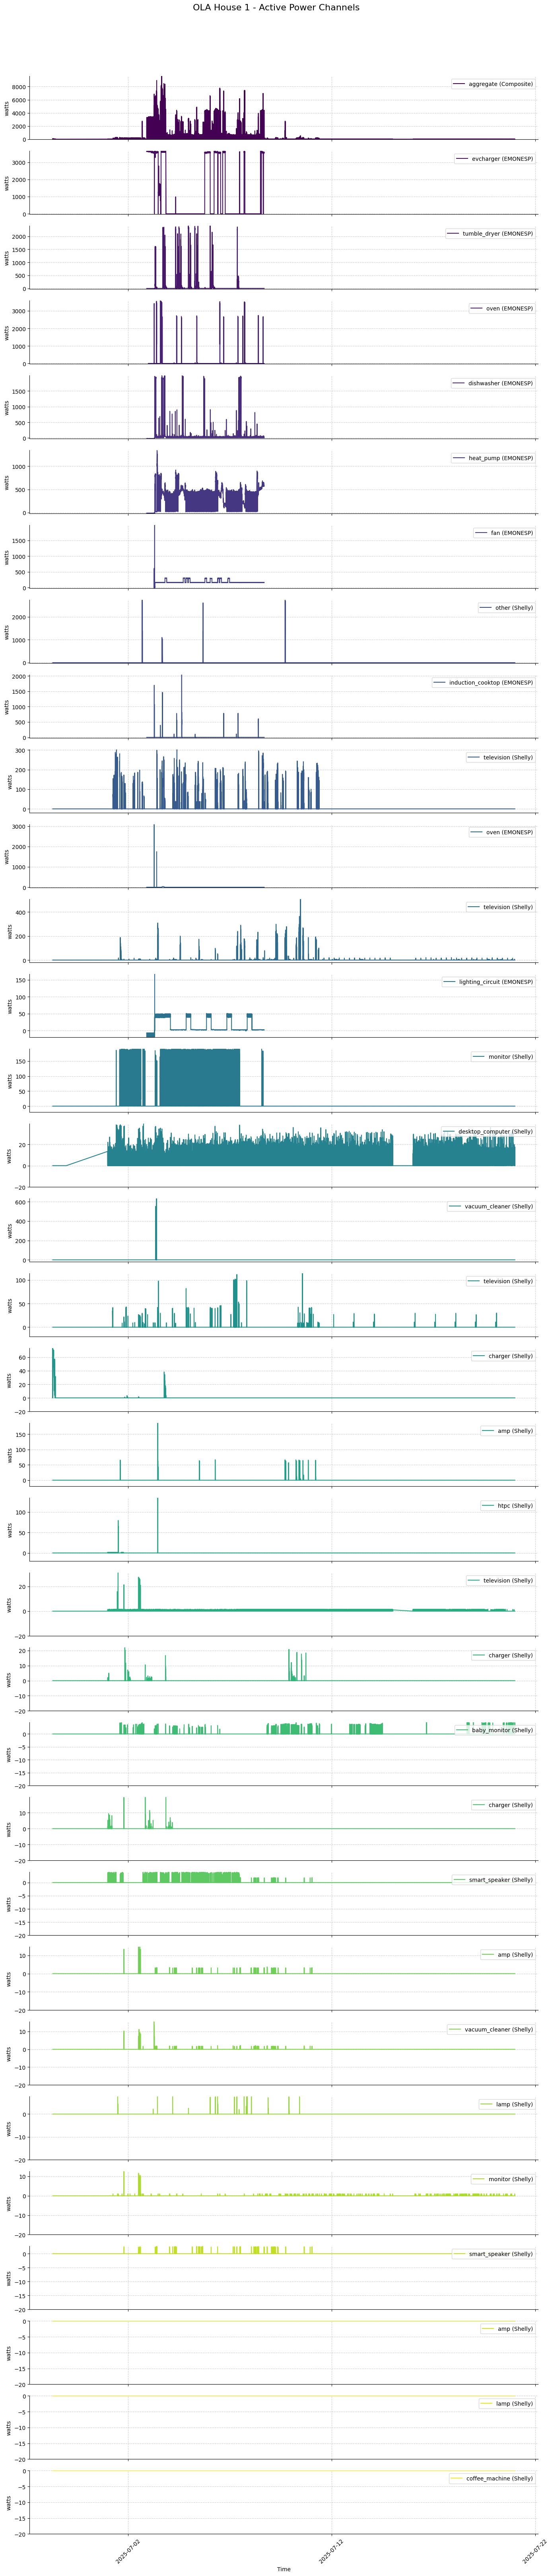

In [7]:
# Reads raw data and stores it as in a standard format
# defined in UnifiedNILM

import sys
import os
sys.path.append(os.path.abspath(".."))
from UnifiedNILM import REFITLoader, UKDALELoader, OlaLoader

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import pandas as pd

# Choose dataset type 
dataset_type = "ola"  # or "ukdale"
print(f'Processing Dataset: {dataset_type}')

# Set preload = true if you nead to read data from raw files during instance initiation (need to do this only once).
# Set preload = false if you nead to read data h5 files for visualization or basic testing.
preload = True 

dataset_root = r'C:\Users\brind\OneDrive - Universitetet i Oslo\Codes\Alva\datasets'
dataset_path = os.path.join(dataset_root, dataset_type)

# Load dataset
if dataset_type == "ukdale":
    dataset = UKDALELoader(dataset_name="ukdale", path=dataset_path, preload_metadata=preload)
elif dataset_type == "refit":
    dataset = REFITLoader(dataset_name="refit", path=dataset_path, preload_metadata=preload)
elif dataset_type == 'ola':
    dataset = OlaLoader(dataset_name="ola", path=dataset_path, preload_metadata=preload)
else:
    raise ValueError("Unsupported dataset type")

if not preload:
    print('loading from H5...')
    h5path = os.path.join(dataset.path, f'{dataset_type}.h5')
    dataset.load_from_h5(h5path)
    print(dataset.houses)
    
    label_set = sorted(set(dataset.appliances))
    label_to_index = {label: idx for idx, label in enumerate(label_set)}
else:
    output = os.path.join(dataset_path, f'{dataset_type}.h5')
    dataset.save_to_h5(output)
    print(f'Dataset {dataset_type} saved to h5')
    # sys.exit()

# Choose a house to inspect
house_id = 1

# Print all channel info
if house_id in dataset.channels:
    print(f"\nChannels in House {house_id}:")
    for ch_id, channel in dataset.channels[house_id].items():
        # print(f" - Channel ID: {ch_id}")
        print(f"   Raw Label : {channel.raw_label}")
        print(f"   Unit      : {channel.unit}")
        print(f"   Data Type : {channel.data_type}")
        print(f"   Data Shape: {channel.data.shape}")
        print(f"   Universal Label: {channel.universal_label}")
        print(f"   Sample Rate: {channel.sample_rate}")
        print(f"   Acq. Device: {channel.acquisition_device}")
        print('-------------------------------------------')
else:
    print(f"House {house_id} not found.")

# sys.exit()

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import pandas as pd
import numpy as np

def plot_house_channels(dataset, house_id, start=None, days=None): 
    """
    Plot active power channels for a given house.
    - Aggregate first if available
    - Channels sorted by variability
    - Time axis marked every 10 days
    - Sequential color map
    - Legend includes acquisition device
    """
    if house_id not in dataset.channels:
        print(f"House {house_id} not found.")
        return

    # Handle time window
    if start:
        start = pd.to_datetime(start)
        end = start + timedelta(days=days) if days else None
    else:
        start = end = None

    all_channels = dataset.channels[house_id]

    # Separate active power channels
    active_channels = {
        ch_id: ch for ch_id, ch in all_channels.items()
        if ch.data_type == "active"
    }

    if not active_channels:
        print(f"No active power channels found for house {house_id}.")
        return

    # Pull out aggregate if present
    aggregate = {}
    if "aggregate" in active_channels:
        aggregate = {"aggregate": active_channels.pop("aggregate")}

    # Compute variability (std) for remaining channels
    variability = {}
    for ch_id, ch in active_channels.items():
        df = ch.data
        if isinstance(df.index, pd.DatetimeIndex):
            if start and end:
                df = df.loc[start:end]
            variability[ch_id] = df.iloc[:, 0].std()
        else:
            variability[ch_id] = -np.inf  # push non-datetime to end

    # Sort by descending std
    sorted_active = dict(sorted(active_channels.items(), key=lambda x: -variability.get(x[0], 0)))

    # Combine
    channels = {**aggregate, **sorted_active}
    n = len(channels)

    # Setup plot
    fig, axs = plt.subplots(n, 1, figsize=(14, 2 * n), sharex=True)
    if n == 1:
        axs = [axs]

    cmap = plt.get_cmap("viridis")  # sequential colormap
    colors = cmap(np.linspace(0, 1, n))

    for i, (channel_id, channel) in enumerate(channels.items()):
        ax = axs[i]
        df = channel.data

        if not isinstance(df.index, pd.DatetimeIndex):
            print(f"Skipping channel {channel.universal_label} (no datetime index)")
            continue

        if start and end:
            df = df.loc[start:end]

        label = f"{channel.universal_label} ({channel.acquisition_device})"
        ax.plot(df.index, df.iloc[:, 0], label=label, color=colors[i])
        ax.set_ylim(-20, df['power'].max())
        ax.set_ylabel(channel.unit)
        ax.legend(loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        if i != n - 1:
            ax.set_xticklabels([])

    axs[-1].set_xlabel("Time")
    axs[-1].xaxis.set_major_locator(mdates.DayLocator(interval=10))
    axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axs[-1].tick_params(axis='x', rotation=45)

    fig.suptitle(f"{dataset.dataset_name.upper()} House {house_id} - Active Power Channels", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


plot_house_channels(dataset, house_id=house_id)
